In [1]:
import numpy as np
import os
import pandas as pd
import itertools
from PIL import Image
import seaborn as sns
import fitsio
import skimage.io
import galsim

from astrometry.util.fits import fits_table, merge_tables


# to make this notebook's output stable across runs
np.random.seed(7)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%load_ext autoreload
%autoreload 2

In [2]:
REPO_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan')
DATA_DIR= os.path.join(os.environ['HOME'],
                       'mydata')

# Galsim: demo[0-9].py

In [3]:
gal_flux = 1.e5    # total counts on the image
rhalf = 2.     # arcsec
psf_sigma = 1.     # arcsec
pixel_scale = 0.2  # arcsec / pixel
noise = 30. # standard 

gal = galsim.Sersic(1,flux=gal_flux, half_light_radius=rhalf)
gal = gal.shear(e1=0.3, e2=-0.8)
rot_gal= gal.rotate(np.pi/2.* galsim.radians)
psf = galsim.Gaussian(flux=1., sigma=psf_sigma) # PSF flux should always = 1
final = galsim.Convolve([gal, psf])
image = final.drawImage(scale=pixel_scale)
image.addNoise(galsim.GaussianNoise(sigma=noise))

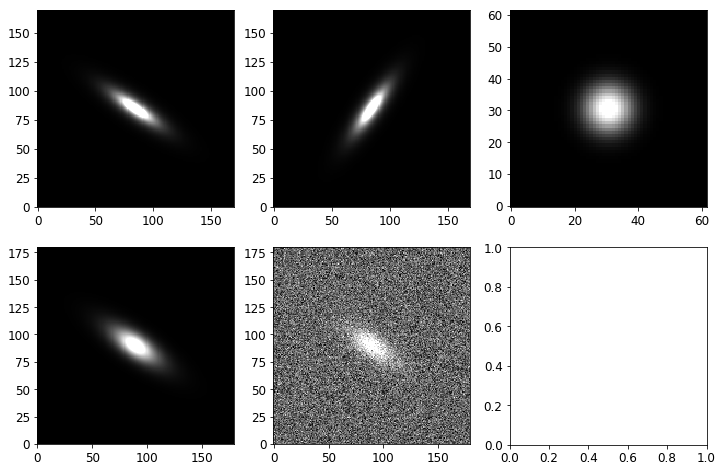

In [4]:
class plotImage(object):
    """Helper functions for displaying image and overlaying circles around sources
    
    Args:
        img: need to give as initial input b/c some helper funcs that dont directly
            use img, need its shape at least, see circles()
    """
    def imshow(self,img,ax,qs=[0.5,99.5]):
        if img.shape[-1] == 3:
            #minmax=np.percentile(np.sum(img,axis=2),q=qs)
            minmax=[None,None]
            cmap=None
        else:
            minmax=np.percentile(img,q=qs)
            cmap='gray'
        ax.imshow(img, interpolation='none', origin='lower',
                  cmap=cmap,vmin=minmax[0],vmax=minmax[1])
        ax.tick_params(direction='out')

fig,ax= plt.subplots(2,3,figsize=(12,8))
kw={'scale':pixel_scale}
plotImage().imshow(gal.drawImage(**kw).array,ax[0,0])
plotImage().imshow(rot_gal.drawImage(**kw).array,ax[0,1])
plotImage().imshow(psf.drawImage(**kw).array,ax[0,2])
plotImage().imshow(final.drawImage(**kw).array,ax[1,0])
plotImage().imshow(image.array,ax[1,1])

In [13]:
ba= np.random.rand(1000)
ba= ba[ba > 0.1]
beta= np.random.rand(len(ba))*180


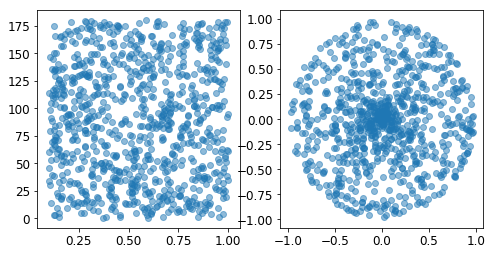

In [20]:
def ellip(q):
    """q: b/a ratio"""
    return (1-q**2)/(1+q**2)

def e1_e2(q,beta):
    """
    q: b/a ratio
    beta: rotation
    """
    e= ellip(q)
    return e*np.cos(2*beta), e*np.sin(2*beta)

fig,ax= plt.subplots(1,2,figsize=(8,4))
ax[0].scatter(ba,beta,alpha=0.5)
e1,e2= e1_e2(ba,beta)
ax[1].scatter(e1,e2,alpha=0.5)

### Can galsim draw all these orientations?

In [19]:
for one,two in zip(e1,e2):
    gal.shear(e1=one, e2=two)

# DECam CCD + PSFex psf

In [5]:
from legacypipe.decam import DecamImage
from legacypipe.survey import LegacySurveyData

In [21]:
ccds= fits_table(os.path.join(DATA_DIR,
                             '1741p242/dr5/legacysurvey-1741p242-ccds.fits'))
t= ccds[((pd.Series(ccds.image_filename).str.contains('c4d_160116_084245_oki_z_v1.fits')) &
         (ccds.ccdname == 'S17'))]
#for col in ['image_filename','ccdname','filter','camera']:
#    t.set(col,t.get(col)[0])
#t

In [47]:
im.get_tractor_image?

In [50]:
survey = LegacySurveyData(ccds=ccds)
for ccd in t:
    im = survey.get_image_object(ccd)
#X = im.get_good_image_subregion()
kwargs = dict(pixPsf=True, splinesky=True, subsky=False,
              pixels=True, dq=True, invvar=True)
tim = im.get_tractor_image(**kwargs)



On NERSC, you can do:
  module use /project/projectdirs/cosmo/work/decam/versions/modules
  module load legacysurvey

Now using the current directory as LEGACY_SURVEY_DIR, but this is likely to fail.

Reading image slice: None
Reading image from /home/kaylan/myrepo/obiwan/doc/nb/images/decam/DECam_CP/CP20160107/c4d_160116_084245_oki_z_v1.fits.fz hdu 15
Reading inverse-variance from /home/kaylan/myrepo/obiwan/doc/nb/images/decam/DECam_CP/CP20160107/c4d_160116_084245_oow_z_v1.fits.fz hdu 15
Reading data quality from /home/kaylan/myrepo/obiwan/doc/nb/images/decam/DECam_CP/CP20160107/c4d_160116_084245_ood_z_v1.fits.fz hdu 15
Reading merged spline sky models from /home/kaylan/myrepo/obiwan/doc/nb/calib/decam/splinesky-merged/00511/decam-00511967.fits
Found 1 matching CCD
Reading merged PsfEx models from /home/kaylan/myrepo/obiwan/doc/nb/calib/decam/psfex-merged/00511/decam-00511967.fits
Found 1 matching CCD
Using PSF model PixelizedPsfEx
-- creating constant PSF model for norms...
PSF norm:

In [51]:
tim.getImage().max(),tim.invvar.shape,tim.data.shape,tim.dq.shape

(77.765678, (4094, 2046), (4094, 2046), (4094, 2046))

In [31]:
psf = tim.psf
wcs = tim.wcs.wcs
sky = tim.sky

## tim.getImage() and the CP CCD have different units. What are they?

In [55]:
hdu=fitsio.FITS('images/decam/DECam_CP/CP20160107/c4d_160116_084245_oki_z_v1.fits.fz')
cp=hdu['S17'].read()
cp.max(), tim.getImage().max()

(51861.047, 77.765678)

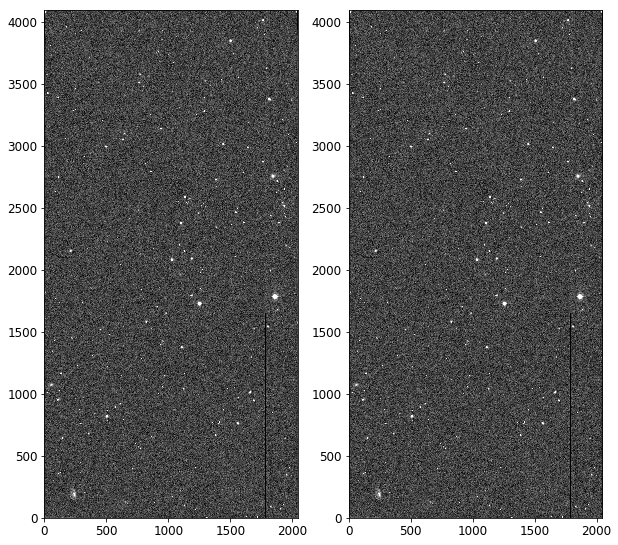

In [56]:
fig,ax= plt.subplots(1,2,figsize=(10,10))
plotImage().imshow(tim.getImage(),ax[0])
plotImage().imshow(cp,ax[1])
#psfim = self.psf.getPointSourcePatch(self.xpos, self.ypos).getImage()

## How does the PSF vary across the CCD image?